In [1]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans

In [2]:
# Original dataset path
original_dir = r"C:\Users\Gowtham reddy\DM_4\GowthamImages"

# Path to save resized images
resized_dir = r"C:\Users\Gowtham reddy\DM_4\ResizedImages"
os.makedirs(resized_dir, exist_ok=True)  # Create the folder if it doesn't exist

# Create subfolders for each class in the resized directory
for class_folder in os.listdir(original_dir):
    class_path = os.path.join(resized_dir, class_folder)
    os.makedirs(class_path, exist_ok=True)

In [3]:
def resize_images():
    for class_folder in os.listdir(original_dir):
        original_class_path = os.path.join(original_dir, class_folder)
        resized_class_path = os.path.join(resized_dir, class_folder)
        
        if os.path.isdir(original_class_path):
            for image_file in os.listdir(original_class_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(original_class_path, image_file)
                    img = Image.open(img_path).convert('RGB')
                    
                    # Resize and save the image
                    img_resized = img.resize((224, 224))
                    img_resized.save(os.path.join(resized_class_path, image_file))

resize_images()
print("All images have been resized and saved.")

All images have been resized and saved.


In [4]:
# Define normalization transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to normalize an image and return it as a tensor
def normalize_images():
    normalized_features = []
    labels = []

    for class_folder in os.listdir(resized_dir):
        class_path = os.path.join(resized_dir, class_folder)
        
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_path, image_file)
                    img = Image.open(img_path).convert('RGB')
                    
                    # Normalize the image
                    img_normalized = transform(img).numpy()
                    normalized_features.append(img_normalized)
                    labels.append(class_folder)
    
    return np.array(normalized_features), np.array(labels)

features_normalized, labels_normalized = normalize_images()
print(f"Normalized features shape: {features_normalized.shape}")

Normalized features shape: (751, 3, 224, 224)


In [5]:
# Load pre-trained ResNet18 model
model = resnet18(pretrained=True)
model.eval()

C:\Users\Gowtham reddy\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gowtham reddy\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
import torch
# Remove the last fully connected layer to use as a feature extractor
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# Extract features from ResNet18
def extract_features():
    features = []
    labels = []

    for class_folder in os.listdir(resized_dir):
        class_path = os.path.join(resized_dir, class_folder)
        
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_path, image_file)
                    img = Image.open(img_path).convert('RGB')
                    
                    # Apply transformations (resize + normalize)
                    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
                    
                    with torch.no_grad():
                        feature = feature_extractor(img_tensor).squeeze().numpy()
                        features.append(feature)
                        labels.append(class_folder)

    return np.array(features), np.array(labels)

features_extracted, labels_extracted = extract_features()
print(f"Extracted features shape: {features_extracted.shape}")


Extracted features shape: (751, 512)


In [7]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_extracted)
print(f"Reduced features shape: {features_2d.shape}")

Reduced features shape: (751, 2)


In [8]:
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42).fit(features_2d)
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=42).fit(features_2d)

In [9]:
bisecting_kmeans = BisectingKMeans(n_clusters=4).fit(features_2d)

In [10]:
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42).fit(features_2d)

In [11]:
dbscan = DBSCAN(eps=0.5, min_samples=1).fit(features_2d)  # Adjust eps and min_samples as needed

In this case, eps is set to 0.5, meaning that points within a radius of 0.5 from a given point are considered its neighbors,
min_samples is set to 1, which means a point will be considered a core point if it has at least one neighbor (including itself) within the eps radius.

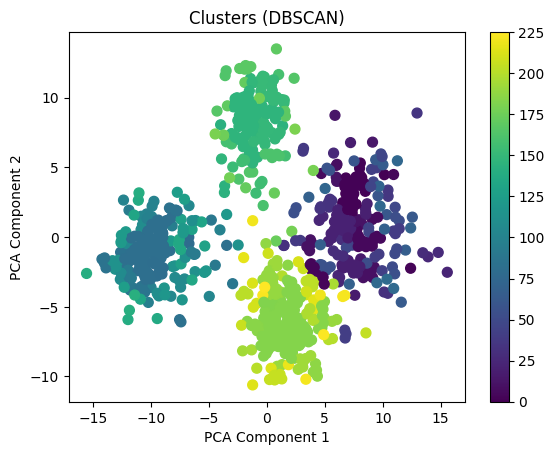

In [21]:
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=dbscan.labels_, cmap='viridis', s=50)
plt.title("Clusters (DBSCAN)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [12]:
linkages = ['ward', 'complete', 'average', 'single']
agglomerative_labels = {}

for linkage in linkages:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=4, linkage=linkage).fit(features_2d)
    agglomerative_labels[linkage] = agglomerative_clustering.labels_

In [19]:
from tabulate import tabulate

methods = {
    'K-means (Random)': kmeans_random.labels_,
    'K-means++': kmeans_plus.labels_,
    'Bisecting K-means': bisecting_kmeans.labels_,
    'Spectral Clustering': spectral_clustering.labels_,
    'DBSCAN': dbscan.labels_,
}

for linkage in agglomerative_labels.keys():
    methods[f'Agglomerative ({linkage})'] = agglomerative_labels[linkage]

fmi_scores = {method: fowlkes_mallows_score(labels_extracted, methods[method]) for method in methods}
silhouette_scores = {method: silhouette_score(features_2d, methods[method]) for method in methods if len(set(methods[method])) > 1}

# Prepare data for tabulation
table_data = []
for method in methods:
    fmi = fmi_scores.get(method, "N/A")
    silhouette = silhouette_scores.get(method, "N/A")
    table_data.append([method, fmi, silhouette])

# Print scores table
print("\nClustering Method Scores:")
print(tabulate(table_data, headers=["Method", "FMI Score", "Silhouette Score"], floatfmt=".4f"))

# Rank methods by scores
fmi_ranked = sorted(fmi_scores.items(), key=lambda x: x[1], reverse=True)
silhouette_ranked = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

# Prepare ranked data for tabulation
fmi_ranked_data = [[method, score] for method, score in fmi_ranked]
silhouette_ranked_data = [[method, score] for method, score in silhouette_ranked]

# Print ranked tables
print("\nRanked by FMI:")
print(tabulate(fmi_ranked_data, headers=["Method", "FMI Score"], floatfmt=".4f"))

print("\nRanked by Silhouette Coefficient:")
print(tabulate(silhouette_ranked_data, headers=["Method", "Silhouette Score"], floatfmt=".4f"))


Clustering Method Scores:
Method                      FMI Score    Silhouette Score
------------------------  -----------  ------------------
K-means (Random)               0.9519              0.5935
K-means++                      0.9491              0.5934
Bisecting K-means              0.8906              0.5636
Spectral Clustering            0.9302              0.5918
DBSCAN                         0.3883              0.0400
Agglomerative (ward)           0.9200              0.5901
Agglomerative (complete)       0.8455              0.5509
Agglomerative (average)        0.7748              0.4996
Agglomerative (single)         0.4998              0.0305

Ranked by FMI:
Method                      FMI Score
------------------------  -----------
K-means (Random)               0.9519
K-means++                      0.9491
Spectral Clustering            0.9302
Agglomerative (ward)           0.9200
Bisecting K-means              0.8906
Agglomerative (complete)       0.8455
Agglomerative (